In [5]:
import os

data_dir = "../../"
data_csv = data_dir + "train.csv"
GRAPHS_DIR = "/plots"

In [6]:
import pandas as pd

data = pd.read_csv(data_csv)

In [7]:
data.columns

Index(['Unnamed: 0', 'timestamp', 'body', 'gender', 'age', 'label'], dtype='object')

In [8]:
i_terms = ["my", "My", "me", "I'm", "i'm", "im", "Me", "I’m", "i’m", "I", "i"]
separator_terms = ['/', ',']

gender_terms = {
        'FFemale': 'female',
        'Ffemale': 'female',
        'Femmale': 'female',
        'Femalle': 'female',
        'Femalee': 'female',
        'Female': 'female',
        'ffemale': 'female',
        'femmale': 'female',
        'femalle': 'female',
        'femalee': 'female',
        'female': 'female',
        'MMale': 'male',
        'Mmale': 'male',
        'Malle': 'male',
        'Malee': 'male',
        'Male': 'male',
        'mmale': 'male',
        'malle': 'male',
        'malee': 'male',
        'male': 'male',
        'm': 'male',
        'M': 'male',
        'f': 'female',
        'F': 'female'
    }

In [9]:
import re

def get_age_gender(row, i_terms, gender_terms, separator_terms, max_distance=5, show_res=False):
    text = row["body"]
    if show_res: print("orig:", text)

    gender = "NA"
    age = "NA"

    # Escape the terms and join them to form part of the regex pattern
    i_terms_pattern = r'\b(' + '|'.join(map(re.escape, i_terms)) + r')\b'
    gender_terms_pattern = r'(' + '|'.join(map(re.escape, gender_terms)) + r')'
    separators_pattern = r'(' + '|'.join(map(re.escape, separator_terms)) + r')'
    age_pattern = r'(\d{1,3}(?=\D|$))'

    # Build the pattern to match either order, with up to max_distance characters and optional whitespace between components
    pattern = \
    fr'{i_terms_pattern}(\s*.{{0,{max_distance}}}?\s*)'+\
    fr'(\(?\s*{age_pattern}\s*\)?\s*{separators_pattern}?\s*\(?\s*{gender_terms_pattern}\b|'+\
    fr'\(?\s*\b{gender_terms_pattern}\)?\s*{separators_pattern}?\s*\(?\s*{age_pattern})'

    match = re.search(pattern, text)

    if match is not None:
        pronoun = match.group(1)
        space = match.group(2)
        details = match.group(3)

        if show_res: print("pronoun:", pronoun)
        if show_res: print("space:", space)
        if show_res: print("details:", details)

        # Replace the gender terms using the provided gender replacement dictionary
        for gender_term in gender_terms:
            if gender_term in details:
                gender = gender_terms[gender_term]
                break

        # Extract the age from the details
        age_match = re.search(r'\d{1,3}(?=\D|$)', details)
        if age_match:
            age = age_match.group(0)
    return pd.Series({
        'age': age,
        'gender': gender
    })


In [10]:
data[['age', 'gender']] = data.apply(get_age_gender, args=(i_terms, gender_terms, separator_terms), axis=1)

In [11]:
data.columns

Index(['Unnamed: 0', 'timestamp', 'body', 'gender', 'age', 'label'], dtype='object')

In [12]:
import numpy as np

data["age"] = data["age"].apply(lambda age: int(age) if age != "NA" else pd.NA)

In [13]:
data["age"] = data["age"].astype("Int64")

In [14]:
data.to_csv(data_dir + "subset2_with_age_gender.csv", index=False)

In [15]:
data["gender"].value_counts()

gender
NA        25464
female     7055
male       4121
Name: count, dtype: int64

In [16]:
data["age"].value_counts()

age
20     741
19     732
22     725
21     718
18     715
      ... 
90       1
164      1
250      1
0        1
370      1
Name: count, Length: 81, dtype: Int64

In [17]:
age_gender_subset = data[(data['gender']!="NA")&(data['age'].notna())&(data['age'] < 100)]

In [18]:
age_gender_subset["gender"].value_counts()

gender
female    7055
male      4085
Name: count, dtype: int64

In [19]:
age_gender_subset["age"].value_counts()

age
20    741
19    732
22    725
21    718
18    715
     ... 
64      1
73      1
75      1
90      1
0       1
Name: count, Length: 74, dtype: Int64

In [20]:
discrep = age_gender_subset["gender"].value_counts()["female"] - age_gender_subset["gender"].value_counts()["male"]
discrep_gender = "female" if discrep > 0 else "male"
print(discrep_gender, "favored, with discrepency of",discrep)

female favored, with discrepency of 2970


In [21]:
age_gender_subset["label"].value_counts()

label
0    7170
1    3970
Name: count, dtype: int64

In [22]:
# Gender Bias Analysis
gender_bias = age_gender_subset.groupby('gender')['label'].value_counts(normalize=True).unstack()

# Age Bucketing
bins = [0, 18, 30, 45, 60, 100]  # Adjust as necessary
labels = ['0-18', '19-30', '31-45', '46-60', '61+']
age_gender_subset['age_bucket'] = pd.cut(age_gender_subset['age'], bins=bins, labels=labels, right=False)

# Age Bias Analysis
age_bias = age_gender_subset.groupby('age_bucket')['label'].value_counts(normalize=True).unstack()

/var/folders/c4/wctb__gj70v0_v8tlv9zqdnr0000gn/T/ipykernel_7558/1884166920.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_gender_subset['age_bucket'] = pd.cut(age_gender_subset['age'], bins=bins, labels=labels, right=False)
/var/folders/c4/wctb__gj70v0_v8tlv9zqdnr0000gn/T/ipykernel_7558/1884166920.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_bias = age_gender_subset.groupby('age_bucket')['label'].value_counts(normalize=True).unstack()


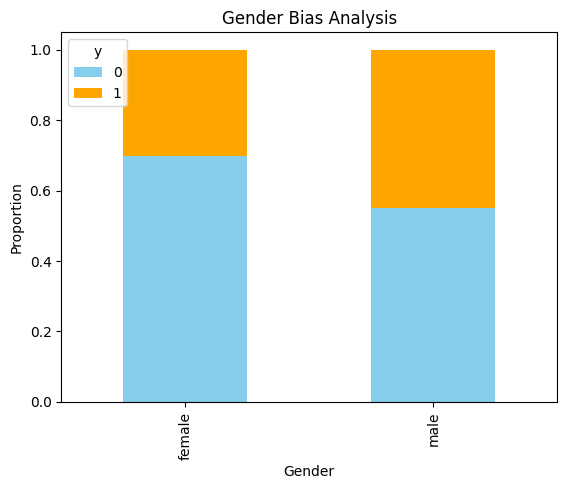

In [24]:
import matplotlib.pyplot as plt

# Plot Gender Bias
gender_bias.plot(kind='bar', stacked=True, color=['skyblue', 'orange'])
plt.title('Gender Bias Analysis')
plt.xlabel('Gender')
plt.ylabel('Proportion')
plt.legend(title='y', loc='upper left')
plt.show()

In [26]:
import pandas as pd
from scipy.stats import chi2_contingency

# Assuming 'data' is your DataFrame

label = age_gender_subset["label"]
female_label = age_gender_subset[age_gender_subset["gender"]=="female"]["label"]
male_label = age_gender_subset[age_gender_subset["gender"]=="male"]["label"]

# Calculate proportions
gender_proportions = age_gender_subset.groupby('gender')['label'].mean()
gender_proportions["overall"] = label.mean()

# Difference in proportions
difference_in_proportions = gender_proportions['female'] - gender_proportions['male']

# Odds Ratio
odds_female = gender_proportions['female'] / (1 - gender_proportions['female'])
odds_male = gender_proportions['male'] / (1 - gender_proportions['male'])
odds_ratio = odds_female / odds_male

# Chi-Square Test
contingency_table = pd.crosstab(data['gender'], data['label'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Display results
print("\nGender Proportions of label=1:")
print(gender_proportions)
print("\nDifference in Proportions (Female - Male):", difference_in_proportions)
print("\nfemale label empirical bias: ", female_label.mean() - label.mean())
print("male label empirical bias: ", male_label.mean() - label.mean())
print("\nOdds Ratio (Female vs Male):", odds_ratio)
print("Odds Ratio indicates bias in favor of", "neither" if abs(odds_ratio - 1) < 0.1 else ("male" if odds_ratio < 1 else "female"))
print("\nChi-Square Test:")
print("Chi2:", chi2, "p-value:", p)
print("Chi-squared p-value indicates", "high bias present" if p < 0.001 else ("bias present" if p < 0.05 else "little bias present"))


Gender Proportions of label=1:
gender
female     0.302339
male       0.449694
overall    0.356373
Name: label, dtype: float64

Difference in Proportions (Female - Male): -0.14735523561594638

female label empirical bias:  -0.0540346622523466
male label empirical bias:  0.09332057336359978

Odds Ratio (Female vs Male): 0.5303180348327763
Odds Ratio indicates bias in favor of male

Chi-Square Test:
Chi2: 1396.60455834526 p-value: 5.384848074876965e-304
Chi-squared p-value indicates high bias present


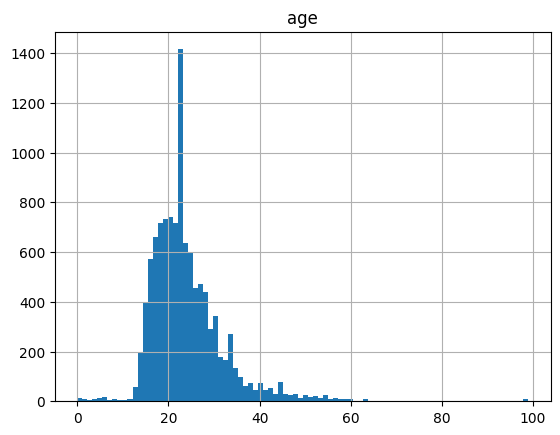

In [27]:
nbins=90
age_hist = age_gender_subset.hist(column="age", bins=nbins)

In [28]:
import pandas as pd

# Assuming 'data' is your DataFrame

# Decide on the number of quantiles/buckets
num_buckets = 5  # You can adjust this number

# Create age buckets using quantiles
age_gender_subset['age_bucket'] = pd.qcut(age_gender_subset['age'], q=num_buckets, labels=False)

# Analyze the distribution of y within each age bucket
age_bucket_bias = age_gender_subset.groupby('age_bucket')['label'].value_counts(normalize=True).unstack()

# Display the buckets with their age ranges
age_ranges = pd.qcut(age_gender_subset['age'], q=num_buckets).unique()

# Print the age ranges and the bias analysis
print("Age Buckets (Ranges):")
for i, age_range in enumerate(age_ranges):
    print(f"Bucket {i}: {age_range}")

print("\nAge Bias Analysis:")
print(age_bucket_bias)


Age Buckets (Ranges):
Bucket 0: (18.0, 21.0]
Bucket 1: (-0.001, 18.0]
Bucket 2: (29.0, 99.0]
Bucket 3: (24.0, 29.0]
Bucket 4: (21.0, 24.0]

Age Bias Analysis:
label              0         1
age_bucket                    
0           0.658519  0.341481
1           0.672296  0.327704
2           0.650755  0.349245
3           0.648337  0.351663
4           0.577537  0.422463


/var/folders/c4/wctb__gj70v0_v8tlv9zqdnr0000gn/T/ipykernel_7558/1527623667.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_gender_subset['age_bucket'] = pd.qcut(age_gender_subset['age'], q=num_buckets, labels=False)


In [29]:
import pandas as pd
from scipy.stats import chi2_contingency

# Assuming 'data' is your DataFrame and age buckets have been created

# Calculate proportions within each age bucket
age_proportions = age_gender_subset.groupby('age_bucket')['label'].mean()

# Calculate the overall proportion of y=1
overall_proportion = age_gender_subset['label'].mean()
age_proportions["overall"] = overall_proportion

# Calculate difference in proportions for each bucket
difference_in_proportions = age_proportions - overall_proportion

# Calculate odds for each bucket
odds_age_buckets = age_proportions / (1 - age_proportions)

# Calculate the overall odds
overall_odds = overall_proportion / (1 - overall_proportion)

# Calculate odds ratio for each bucket relative to the overall odds
odds_ratio_age_buckets = odds_age_buckets / overall_odds
# Create a DataFrame from the odds ratios
odds_ratio_df = odds_ratio_age_buckets.reset_index()
odds_ratio_df.columns = ['age_bucket', 'odds_ratio']

# Add the age ranges as an additional column
age_ranges = pd.qcut(age_gender_subset['age'], q=len(odds_ratio_age_buckets)).unique()
odds_ratio_df['age_range'] = age_ranges
columns = list(odds_ratio_df.columns)
columns.insert(1, columns.pop(-1))

odds_ratio_df["bias"] = ["unbiased" if abs(val - 1) < 0.1 else ("biased" if val > 1 else "anti-biased") for val in odds_ratio_df["odds_ratio"]]

# Chi-Square Test for the age buckets
contingency_table = pd.crosstab(age_gender_subset['age_bucket'], age_gender_subset['label'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Display results
print("Age Buckets (Ranges):")
for i, age_range in enumerate(age_ranges):
    print(f"Bucket {i}: {age_range}")
print("Age Proportions of label=1:")
print(age_proportions)
print("\nDifference in Proportions (Bucket - Overall):")
print(difference_in_proportions)
print("\nOdds Ratio (Each Bucket vs Overall):")
print(odds_ratio_df)
print("Odds Ration indicates", "unbiased if abs(odds_ratio - 1) < 0.1, otherwise biased for this age range (odds_ratio > 1) or against (odds_ratio < 1)")
print("\nChi-Square Test:")
print("Chi2:", chi2, "p-value:", p)
print("Chi-squared p-value indicates", "high bias present" if p < 0.001 else ("bias present" if p < 0.05 else "little bias present"))

Age Buckets (Ranges):
Bucket 0: (20.0, 22.0]
Bucket 1: (-0.001, 17.0]
Bucket 2: (30.0, 99.0]
Bucket 3: (17.0, 20.0]
Bucket 4: (25.0, 30.0]
Bucket 5: (22.0, 25.0]
Age Proportions of label=1:
age_bucket
0          0.341481
1          0.327704
2          0.349245
3          0.351663
4          0.422463
overall    0.356373
Name: label, dtype: float64

Difference in Proportions (Bucket - Overall):
age_bucket
0         -0.014892
1         -0.028669
2         -0.007128
3         -0.004710
4          0.066089
overall    0.000000
Name: label, dtype: float64

Odds Ratio (Each Bucket vs Overall):
  age_bucket  odds_ratio       age_range         bias
0          0    0.936543    (20.0, 22.0]     unbiased
1          1    0.880340  (-0.001, 17.0]  anti-biased
2          2    0.969262    (30.0, 99.0]     unbiased
3          3    0.979613    (17.0, 20.0]     unbiased
4          4    1.321104    (25.0, 30.0]       biased
5    overall    1.000000    (22.0, 25.0]     unbiased
Odds Ration indicates unbiase

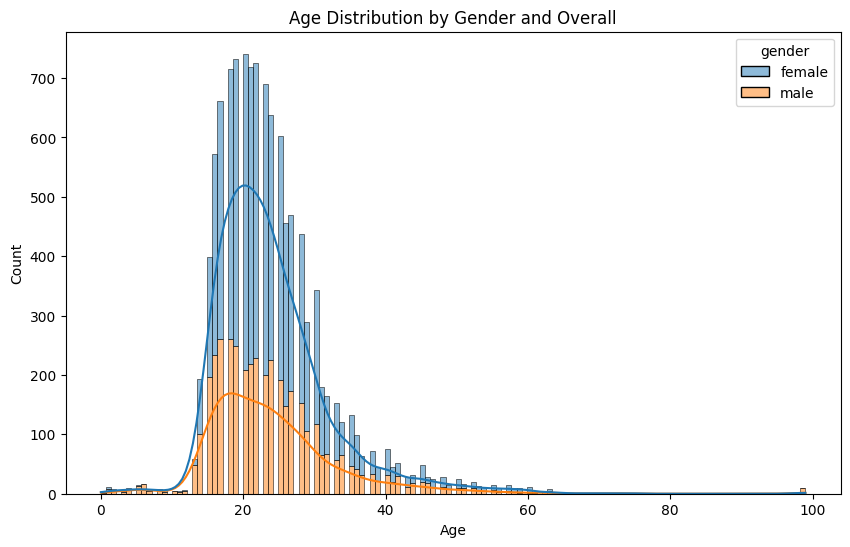

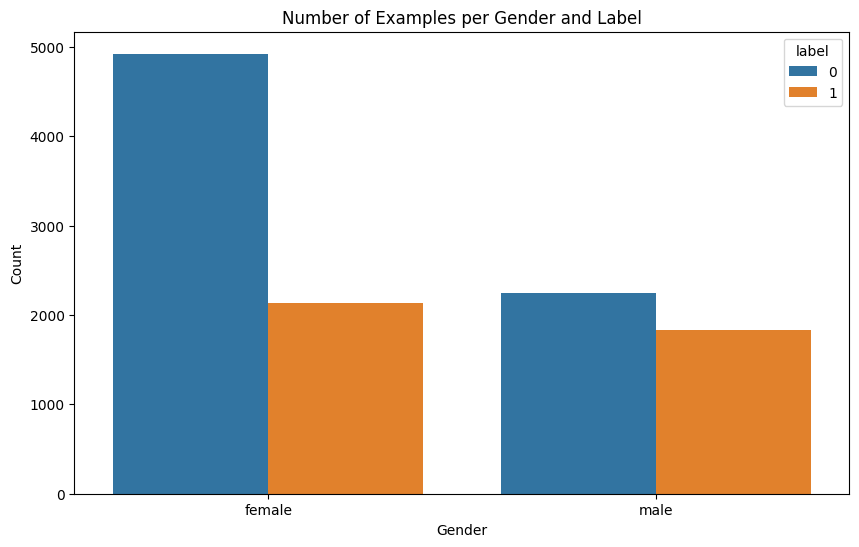

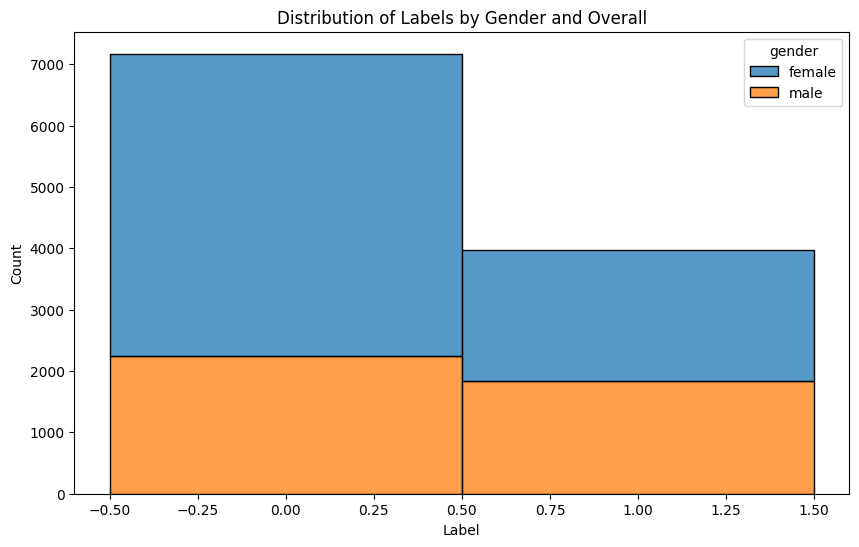

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

graph_dir = data_dir + GRAPHS_DIR
# Ensure the directory exists
os.makedirs(graph_dir, exist_ok=True)

# 1. Distribution of ages for each gender and overall
plt.figure(figsize=(10, 6))
sns.histplot(data=age_gender_subset, x='age', hue='gender', multiple='stack', kde=True)
plt.title('Age Distribution by Gender and Overall')
plt.xlabel('Age')
plt.ylabel('Count')
plt.savefig(os.path.join(graph_dir, 'age_distribution_by_gender.png'))
plt.show()

# 2. Amount of examples per gender and their labels
plt.figure(figsize=(10, 6))
sns.countplot(data=age_gender_subset, x='gender', hue='label')
plt.title('Number of Examples per Gender and Label')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.savefig(os.path.join(graph_dir, 'examples_per_gender_and_label.png'))
plt.show()

# 3. Distribution of labels for each gender and overall
plt.figure(figsize=(10, 6))
sns.histplot(data=age_gender_subset, x='label', hue='gender', multiple='stack', discrete=True)
plt.title('Distribution of Labels by Gender and Overall')
plt.xlabel('Label')
plt.ylabel('Count')
plt.savefig(os.path.join(graph_dir, 'label_distribution_by_gender.png'))
plt.show()
